# Vanilla Models
July 1, 2025

In [50]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import pandas as pd
import plotly.express as px
import seaborn as sns
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
from NTdatasets.conway.synthcloud_datasets import SimCloudData
from NTdatasets.generic import GenericDataset
from ColorDataUtils.multidata_utils import MultiExperiment
import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils.Barcode import Barcode
from ColorDataUtils import readout_fit
from ColorDataUtils.simproj_utils import *
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss
from NDNT.utils import subplot_setup
from NDNT.utils import figure_export

# Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA
from scipy.spatial import distance_matrix
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [2]:
start    = time.time()
data     = SimCloudData(down_sample=3, num_lags=11)
end      = time.time()
print('CPU Time', end-start, 'sec')

CPU Time 50.93075394630432 sec


In [3]:
start     = time.time()
test_data = SimCloudData(filename='cloud_TEST_data_stim_dim120_spike_time_sqrad_0.3.hdf5', down_sample=3, num_lags=11, test=True)
end       = time.time()
print('CPU Time', end-start, 'sec')

test_robs = test_data.repeat_robs
test_dfs = test_data.repeat_dfs
print(test_robs.shape)
print(test_dfs.shape)

CPU Time 15.86441969871521 sec
(30000, 10, 1491)
(30000, 10, 1491)


In [4]:
# Load baseline LL
GLM_LL = np.load('data/2-28_update_cloud_data_stim_dim_120_sqrad_0.3_GLM_LL.npy')
GQM_LL = np.load('data/2-28_update_cloud_data_stim_dim_120_sqrad_0.3_GQM_LL.npy')

# Load baseline LL
GLM_R2 = np.load('data/cloud_test_data_stim_dim_120_sqrad_0.3_GLM_R2.npy')
GQM_R2 = np.load('data/cloud_test_data_stim_dim_120_sqrad_0.3_GQM_R2.npy')

In [5]:
# Load Complexity Index (calculated from GQM)
comp = np.load('data/2-28_update_all_neuron_complexity_sqrad_0.3.npy')

In [6]:
cell_idx_dict = data.cell_idx_dict
thetas_dict = data.thetas
V1_thetas = np.concatenate((thetas_dict['V1_Exc_L4'], thetas_dict['V1_Inh_L4'], thetas_dict['V1_Exc_L2/3'], thetas_dict['V1_Inh_L2/3']))

L4_exc_idx = cell_idx_dict['V1_Exc_L4']
L4_inh_idx = cell_idx_dict['V1_Inh_L4']
L23_exc_idx = cell_idx_dict['V1_Exc_L2/3']
L23_inh_idx = cell_idx_dict['V1_Inh_L2/3']

In [7]:
mu0s = data.mu0s
stim_dims = data.stim_dims
num_lags = data.num_lags
L  = stim_dims[1]
NC = data.NC
NT = data.NT
print('stim_dims =', stim_dims)
print('num_lags =', num_lags)
print('L =', L)
print('Number of cells', NC)
print('Number of time points', NT)

stim_dims = [1, 40, 40, 1]
num_lags = 11
L = 40
Number of cells 1491
Number of time points 480000


In [8]:
# cell key
cell_key = data.cell_key

# integer cell key
int_key = np.zeros(NC)
int_key[L4_exc_idx] = 1
int_key[L4_inh_idx] = 2
int_key[L23_exc_idx] = 3
int_key[L23_inh_idx] = 4

# cell key dict
key_dict = {}
key_dict['L4_exc'] = 1
key_dict['L4_inh'] = 2
key_dict['L23_exc'] = 3
key_dict['L23_inh'] = 4

colors = ['tab:blue', 'tab:cyan', 'tab:red', 'm']

In [9]:
# Compute Average Robs
robs = deepcopy(data[:]['robs']).numpy()
dfs = deepcopy(data[:]['dfs']).numpy()
avg_robs = np.zeros(NC)
for i in range(NC):
    idx = np.where(dfs[:,i] == 1)[0]
    avg_robs[i] = np.mean(robs[idx,i])

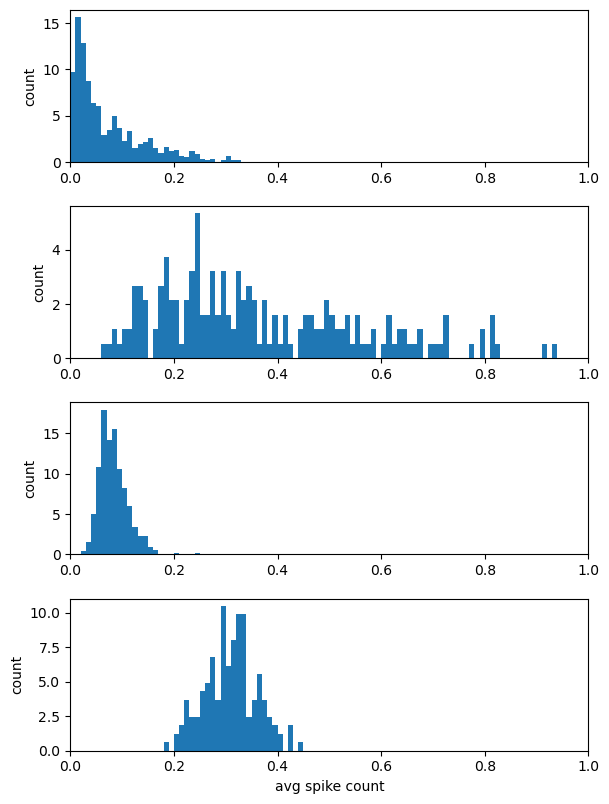

In [10]:
subplot_setup(4, 1, row_height=2, fig_width=6)
plt.subplot(4,1,1)
plt.hist(avg_robs[L4_exc_idx], bins=np.arange(0,1,0.01), density=True)
plt.xlim(0,1)
plt.ylabel('count')
plt.subplot(4,1,2)
plt.hist(avg_robs[L4_inh_idx], bins=np.arange(0,1,0.01), density=True)
plt.xlim(0,1)
plt.ylabel('count')
plt.subplot(4,1,3)
plt.hist(avg_robs[L23_exc_idx], bins=np.arange(0,1,0.01), density=True)
plt.xlim(0,1)
plt.ylabel('count')
plt.subplot(4,1,4)
plt.hist(avg_robs[L23_inh_idx], bins=np.arange(0,1,0.01), density=True)
plt.xlim(0,1)
plt.ylabel('count')
plt.xlabel('avg spike count')
plt.show()

## Model Params

In [11]:
# Adam Parameters
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=1,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay=0.2, accumulate_grad_batches=5)
adam_pars['device'] = device

In [12]:
#=====Vanilla Model=====
Treg = 0.0001
Xreg = 0.003 # d2/dx
Creg = 0.00001 # center
MaxReg = 0.001 # readout reg

num_subs = [32, 32, 32]
fws = [24, 9, 9]

clayers = []

for ii in range(len(fws)):
    if ii == 0:
        clayers.append(STconvLayer.layer_dict(
        input_dims = data.stim_dims, num_filters=num_subs[ii], num_inh=0,
        filter_dims=[1,fws[ii],fws[ii],num_lags],
        bias=False, norm_type=1, initialize_center=True, output_norm='batch',
        NLtype='relu', reg_vals={'d2t':Treg, 'd2x':Xreg, 'center': Creg}))
    else:
        clayers.append(ConvLayer.layer_dict(
        num_filters=num_subs[ii], num_inh=0, filter_dims=fws[ii],
        bias=False, norm_type=1, initialize_center=True, output_norm='batch',
        NLtype='relu'))

scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='normal', xstim_n='stim', layer_list=clayers)

readout_pars = ReadoutLayer.layer_dict(
    num_filters=NC, NLtype='softplus', bias=True, pos_constraint=False,
    reg_vals={'max': MaxReg})

readout_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0],
    layer_list = [readout_pars], ffnet_type='readout')

In [13]:
cnn = NDN(ffnet_list = [scaffold_net, readout_net], loss_type='poissonL', seed=100)
print(cnn.info())
print(cnn.list_parameters())

ConvDim 1 should be odd.
ConvDim 2 should be odd.
NDN poissonL, output net #1:
  0 normal: Input = 'stim' [1, 40, 40, 1]
    0 STconv11:  32 (i0)  [relu] w24 NB		{'d2t': 0.0001, 'd2x': 0.003, 'center': 1e-05}
    1   conv2d:  32 (i0)  [relu] w9  NB		
    2   conv2d:  32 (i0)  [relu] w9  NB		
  1 readout: Input = ffnet 0 [32, 40, 40, 1]
    0  readout: 1491 (i0)  [soft]  bias		{'max': 0.001}
None
Network 0:
  Layer 0:
      weight: torch.Size([6336, 32])
  Layer 1:
      weight: torch.Size([2592, 32])
  Layer 2:
      weight: torch.Size([2592, 32])
Network 1:
  Layer 0:
      weight: torch.Size([32, 1491])
      bias: torch.Size([1491])
      mu: torch.Size([1491, 2])
      sigma: torch.Size([1491, 1])
None


In [14]:
#=====From Scratch Set Model=====
# Network 1: set mu values
cnn.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
cnn.networks[1].layers[0].fit_mus(True)
cnn.block_sample = True
cnn.loss_module.unit_weighting = True

  ReadoutLayer: fitting mus


In [15]:
cnn.fit(data, **adam_pars, verbose=3)
cnn.save_model('models/0708_vanilla_loss_unit_weights.ndn')

GPU Available: True, GPU Used: True
Model: NDN491_N3_R1, version 2


Validating ver=2: 100%|███████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 14.94it/s, val_loss=0.305401]


=> EarlyStopping counter: 1 out of 4


Validating ver=2: 100%|███████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 14.47it/s, val_loss=0.132545]


=> EarlyStopping counter: 1 out of 4


Validating ver=2: 100%|███████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 14.09it/s, val_loss=0.135416]


=> EarlyStopping counter: 2 out of 4


Validating ver=2: 100%|███████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 15.34it/s, val_loss=0.133992]


=> EarlyStopping counter: 3 out of 4


Validating ver=2: 100%|███████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 15.16it/s, val_loss=0.133345]


=> EarlyStopping counter: 1 out of 4


Validating ver=2: 100%|████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 15.32it/s, val_loss=0.13119]


=> EarlyStopping counter: 1 out of 4


Validating ver=2: 100%|███████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 15.11it/s, val_loss=0.130293]


=> EarlyStopping counter: 2 out of 4


Validating ver=2: 100%|███████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 15.27it/s, val_loss=0.132201]


=> EarlyStopping counter: 3 out of 4


Validating ver=2: 100%|███████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 14.58it/s, val_loss=0.132319]

=> EarlyStopping counter: 4 out of 4
Early stopping
Done fitting
  Fit complete: 2508.43 sec elapsed
  Model saved:  models/0708_vanilla_loss_unit_weights.ndn


## Performance

In [17]:
test_pred = cnn.predictions(test_data, data_inds=np.arange(test_data.NB), batch_size=1, num_lags=num_lags, device=device).detach().cpu().numpy()
print(test_pred.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.36it/s]


(30000, 1491)


In [18]:
R2 = comp_test_R2(test_robs, test_dfs, test_pred)

In [19]:
print('R2 array shape', R2.shape)
print('R2 mean', np.mean(R2))
print('L4 Exc Mean R2:', np.mean(R2[L4_exc_idx]), '+/-', np.std(R2[L4_exc_idx]))
print('L4 Inh Mean R2:', np.mean(R2[L4_inh_idx]), '+/-', np.std(R2[L4_inh_idx]))
print('L2/3 Exc Mean R2:', np.mean(R2[L23_exc_idx]), '+/-', np.std(R2[L23_exc_idx]))
print('L2/3 Inh Mean R2:', np.mean(R2[L23_inh_idx]), '+/-', np.std(R2[L23_inh_idx]))

R2 array shape (1491,)
R2 mean 0.42119888757012214
L4 Exc Mean R2: 0.48033140480538933 +/- 0.19345303860185498
L4 Inh Mean R2: 0.6546699264867908 +/- 0.10039014016965289
L2/3 Exc Mean R2: 0.3082306084713571 +/- 0.11377556259764826
L2/3 Inh Mean R2: 0.303208190524536 +/- 0.0966067724492508


Text(0.5, 1.0, 'Layer 2/3 Inh')

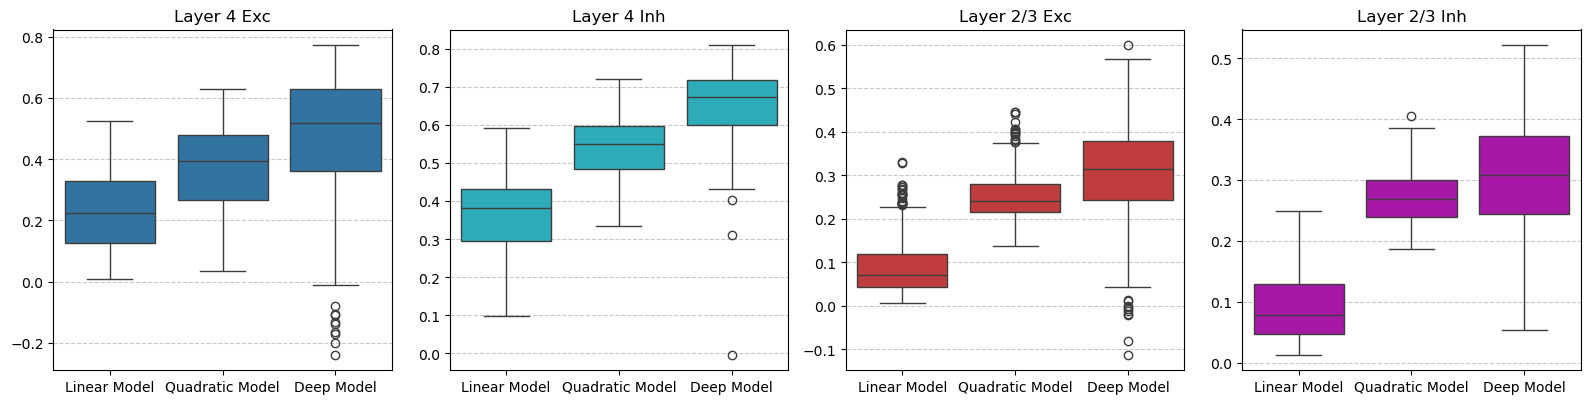

In [20]:
ss(1,4)
plt.subplot(1,4,1)
R2_to_plot = [GLM_R2[L4_exc_idx], GQM_R2[L4_exc_idx], R2[L4_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.boxplot(data=R2_to_plot, color=colors[0])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Exc')

plt.subplot(1,4,2)
R2_to_plot = [GLM_R2[L4_inh_idx], GQM_R2[L4_inh_idx], R2[L4_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.boxplot(data=R2_to_plot, color=colors[1])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Inh')

plt.subplot(1,4,3)
R2_to_plot = [GLM_R2[L23_exc_idx], GQM_R2[L23_exc_idx], R2[L23_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.boxplot(data=R2_to_plot, color=colors[2])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Exc')

plt.subplot(1,4,4)
R2_to_plot = [GLM_R2[L23_inh_idx], GQM_R2[L23_inh_idx], R2[L23_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.boxplot(data=R2_to_plot, color=colors[3])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Inh')

## Barcode Set Up

In [21]:
BC = Barcode(cnn, data, layer_list=[2])

In [30]:
W = BC.get_barcode(space='filter')
W.shape

(32, 1491)

Text(0.5, 25.722222222222214, 'Neuron')

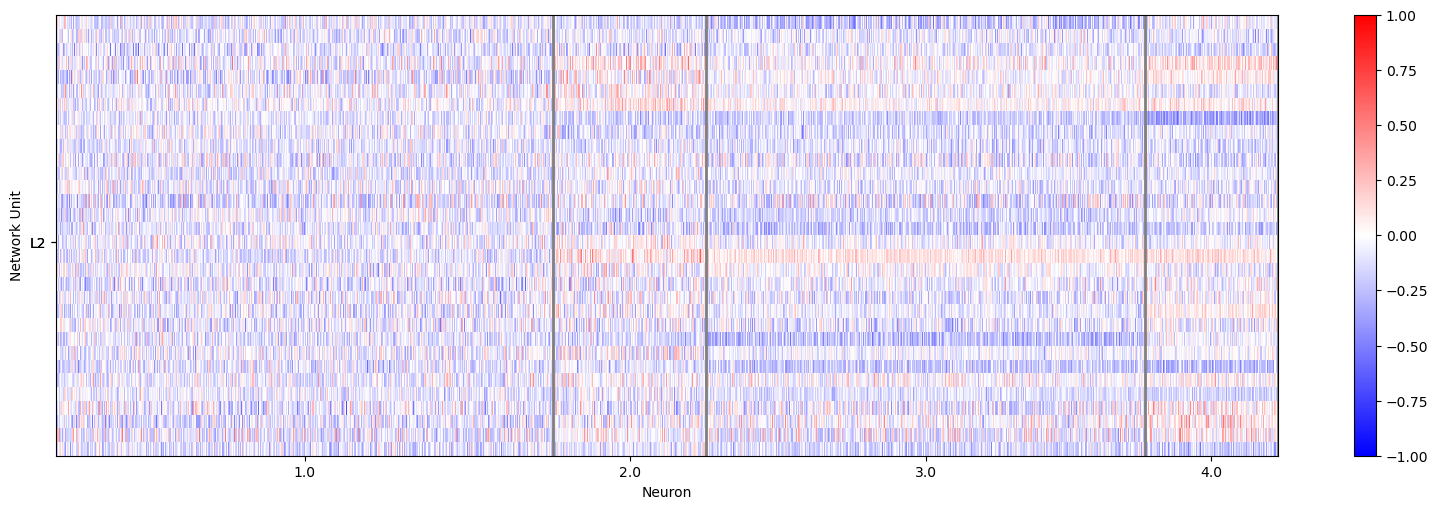

In [22]:
BC.plot_barcode(labels=int_key)
plt.ylabel('Network Unit')
plt.xlabel('Neuron')

(-0.5, 1490.5, 1490.5, -0.5)

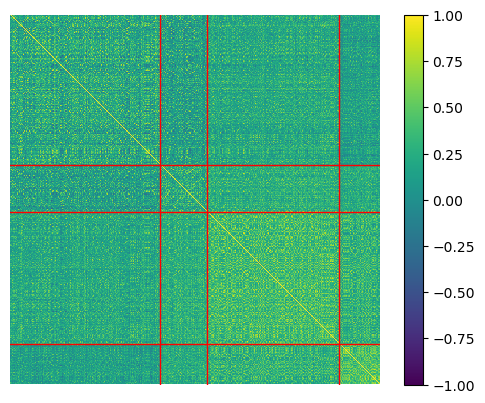

In [41]:
BC.cosine_similarity(plot=True)
plt.clim(-1,1)
plt.axvline(x=L4_exc_idx[-1], color='red', lw=1)
plt.axhline(y=L4_exc_idx[-1], color='red', lw=1)
plt.axvline(x=L4_inh_idx[-1], color='red', lw=1)
plt.axhline(y=L4_inh_idx[-1], color='red', lw=1)
plt.axvline(x=L23_exc_idx[-1], color='red', lw=1)
plt.axhline(y=L23_exc_idx[-1], color='red', lw=1)
plt.axis('off')

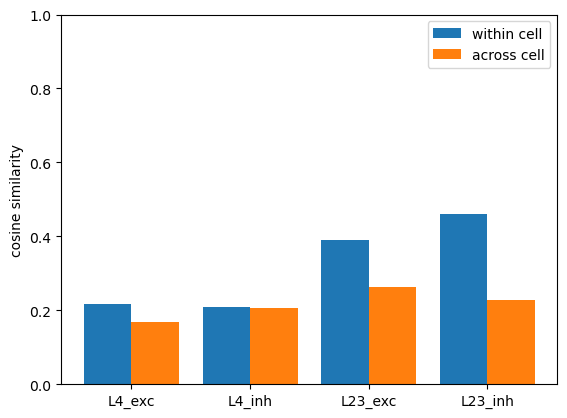

In [24]:
BC.sim_vs_diff_bar_plot(labels=int_key, labels_key=key_dict)

Text(0.5, 25.722222222222214, 'Neuron')

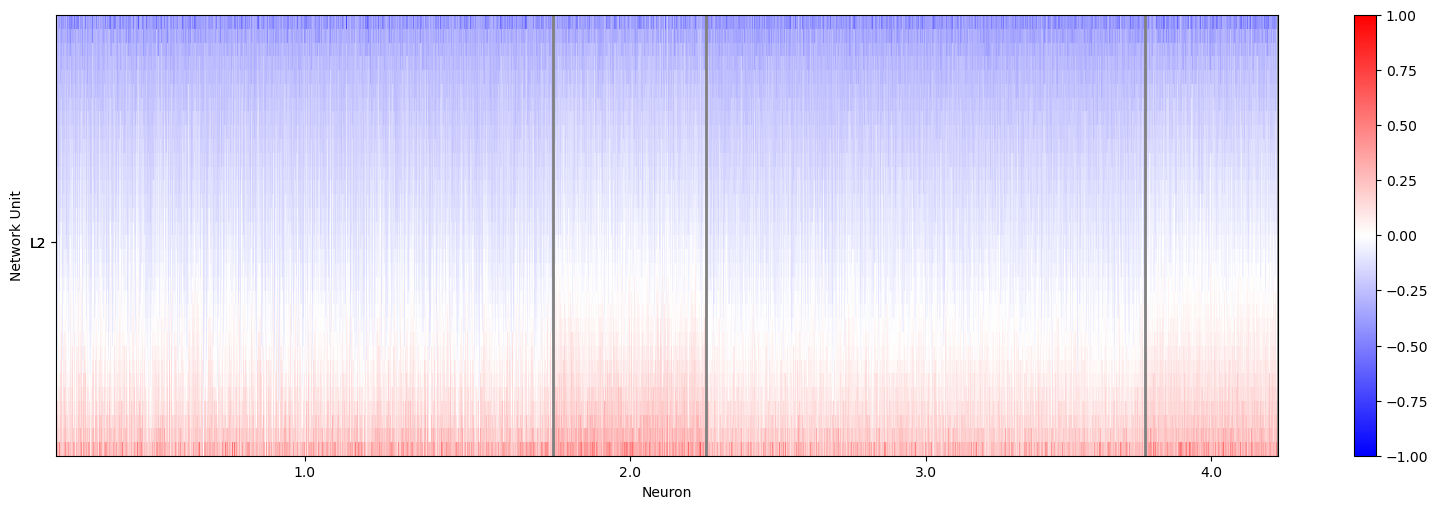

In [25]:
BC.plot_barcode(labels=int_key, space='sorted')
plt.ylabel('Network Unit')
plt.xlabel('Neuron')

(-0.5, 1490.5, 1490.5, -0.5)

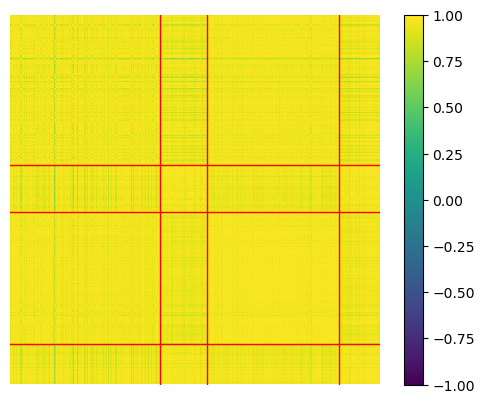

In [42]:
BC.cosine_similarity(plot=True, space='sorted')
plt.clim(-1,1)
plt.axvline(x=L4_exc_idx[-1], color='red', lw=1)
plt.axhline(y=L4_exc_idx[-1], color='red', lw=1)
plt.axvline(x=L4_inh_idx[-1], color='red', lw=1)
plt.axhline(y=L4_inh_idx[-1], color='red', lw=1)
plt.axvline(x=L23_exc_idx[-1], color='red', lw=1)
plt.axhline(y=L23_exc_idx[-1], color='red', lw=1)
plt.axis('off')

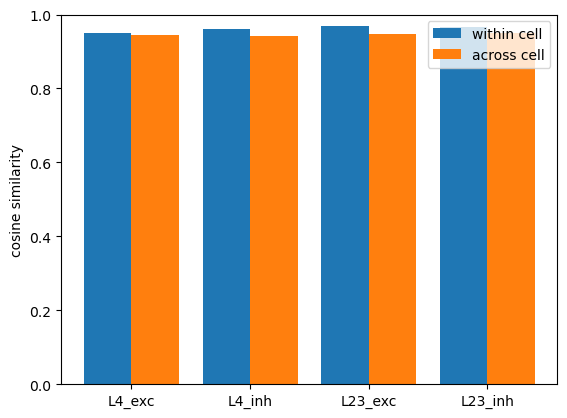

In [27]:
BC.sim_vs_diff_bar_plot(labels=int_key, labels_key=key_dict, space='sorted')

## Cluster --> LR

In [28]:
BC.set_cells()
space = 'filter'
params={'linkage': 'ward', 'metric': 'euclidean', 'compute_distances': True}
ac_2k = BC.cluster(space=space, method='agg', params=params, n_clusters=2)
ac_pred = ac_2k.labels_

#space = 'filter'
b_hat, basis, proj1, D_prime = BC.fit_log_reg(labels=ac_pred, space=space)
print('D-prime:', D_prime)

D-prime: 3.0315977439753095


AC D-prime 0.19394104639714266


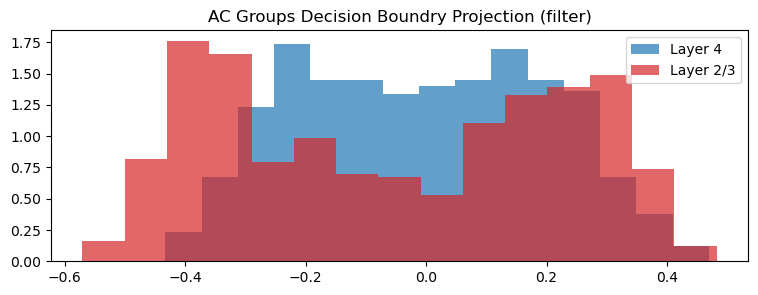

In [29]:
mean1 = np.mean(proj1[L4_exc_idx+L4_inh_idx])
std1 = np.std(proj1[L4_exc_idx+L4_inh_idx])
mean2 = np.mean(proj1[L23_exc_idx+L23_inh_idx])
std2 = np.std(proj1[L23_exc_idx+L23_inh_idx])
ac_Dp = np.abs(mean1-mean2)/np.sqrt(std1*std2)
print('AC D-prime', ac_Dp)

plt.figure(figsize=(9,3))
plt.hist(proj1[L4_exc_idx+L4_inh_idx] ,bins=15, label='Layer 4', alpha=0.7, density=True, color=colors[0])
plt.hist(proj1[L23_exc_idx+L23_inh_idx] ,bins=15, label='Layer 2/3', alpha=0.7, density=True, color=colors[2])
plt.title('AC Groups Decision Boundry Projection ('+space+')')
plt.legend()
plt.show()

## T-SNE --> Cluster --> LR

In [30]:
BC.set_cells()
space = 'filter'
dim_list = [2,3,4,5,6,7,8]
for i in range(len(dim_list)):
    BC.dim_reduction(method='tsne', name=str(dim_list[i])+'D tsne', n_dim=dim_list[i], space=space, perplexity=50)

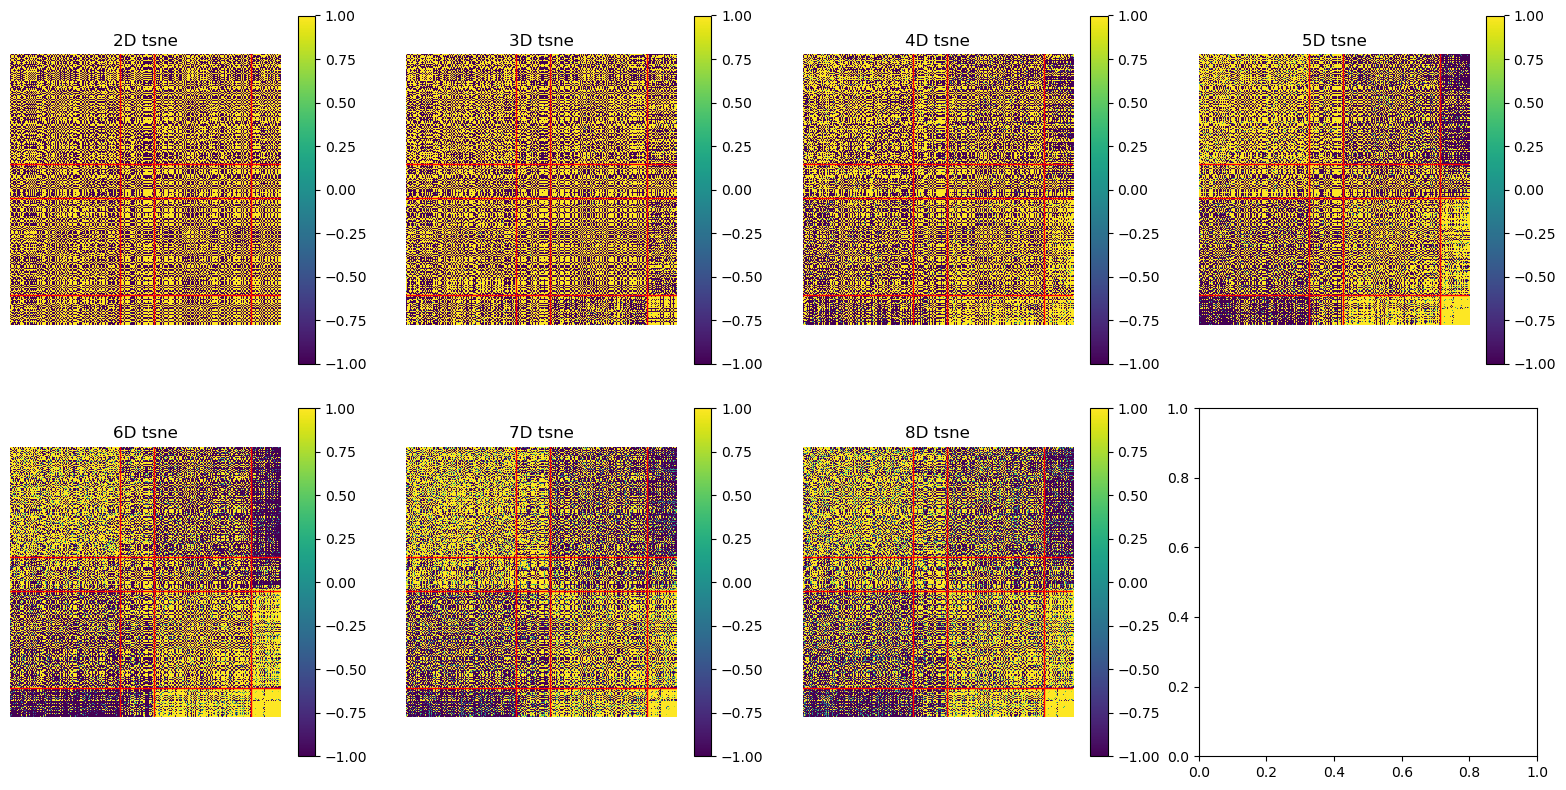

In [31]:
ss(2,4)
for i in range(len(dim_list)):
    plt.subplot(2,4,i+1)
    BC.cosine_similarity(space=str(dim_list[i])+'D tsne', plot=True, cmin=-1)
    plt.title(str(dim_list[i])+'D tsne')
    plt.axvline(x=L4_exc_idx[-1], color='red', lw=1)
    plt.axhline(y=L4_exc_idx[-1], color='red', lw=1)
    plt.axvline(x=L4_inh_idx[-1], color='red', lw=1)
    plt.axhline(y=L4_inh_idx[-1], color='red', lw=1)
    plt.axvline(x=L23_exc_idx[-1], color='red', lw=1)
    plt.axhline(y=L23_exc_idx[-1], color='red', lw=1)
    plt.axis('off')

In [36]:
BC.set_cells()
space = 'filter'
BC.dim_reduction(method='tsne', name='5D tsne', n_dim=5, space=space, perplexity=50)

(-0.5, 1490.5, 1490.5, -0.5)

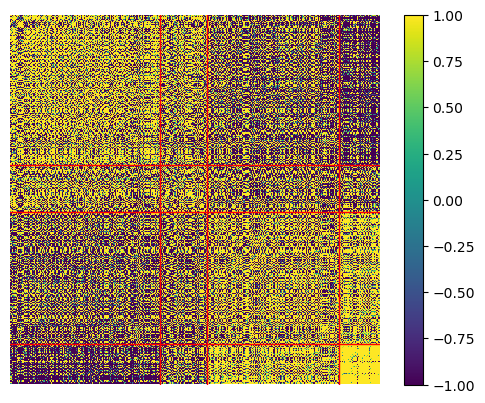

In [54]:
BC.cosine_similarity(space='8D tsne', plot=True, cmin=-1)
#plt.clim(-1,1)
plt.axvline(x=L4_exc_idx[-1], color='red', lw=1)
plt.axhline(y=L4_exc_idx[-1], color='red', lw=1)
plt.axvline(x=L4_inh_idx[-1], color='red', lw=1)
plt.axhline(y=L4_inh_idx[-1], color='red', lw=1)
plt.axvline(x=L23_exc_idx[-1], color='red', lw=1)
plt.axhline(y=L23_exc_idx[-1], color='red', lw=1)
plt.axis('off')

In [55]:
space = '8D tsne'
params={'linkage': 'ward', 'metric': 'euclidean', 'compute_distances': True}
BC.set_cells()
ac = BC.cluster(space=space, method='agg', params=params, n_clusters=4)
ac_pred = ac.labels_

a_hat, basis, proj, D_prime = BC.fit_log_reg(labels=ac_pred, space='filter')

In [56]:
group0_idx = list(np.where(ac_pred==0)[0])
group1_idx = list(np.where(ac_pred==1)[0])
group2_idx = list(np.where(ac_pred==2)[0])
group3_idx = list(np.where(ac_pred==3)[0])

(-0.5, 1490.5, 1490.5, -0.5)

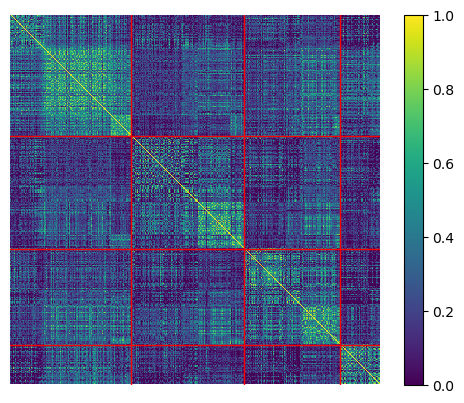

In [57]:
BC.set_cells()
BC.set_cells(group0_idx+group1_idx+group2_idx+group3_idx)
BC.cosine_similarity(space='filter', plot=True, cmin=0)
plt.axvline(x=len(group0_idx)-0.5, color='red', lw=1)
plt.axvline(x=len(group0_idx+group1_idx)-0.5, color='red', lw=1)
plt.axvline(x=len(group0_idx+group1_idx+group2_idx)-0.5, color='red', lw=1)
plt.axhline(y=len(group0_idx)-0.5, color='red', lw=1)
plt.axhline(y=len(group0_idx+group1_idx)-0.5, color='red', lw=1)
plt.axhline(y=len(group0_idx+group1_idx+group2_idx)-0.5, color='red', lw=1)
#plt.clim(-1,1)
plt.axis('off')

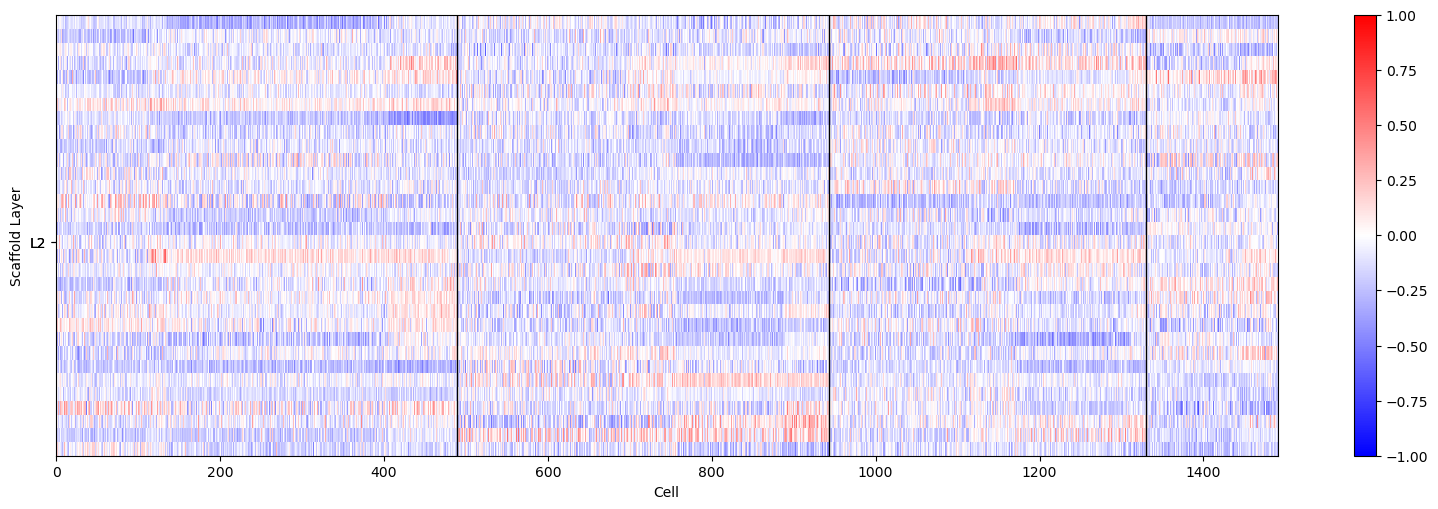

In [58]:
BC.set_cells()
BC.set_cells(group0_idx+group1_idx+group2_idx+group3_idx)
BC.plot_barcode(space='filter')
plt.axvline(x=len(group0_idx)-0.5, color='black', lw=1)
plt.axvline(x=len(group0_idx+group1_idx)-0.5, color='black', lw=1)
plt.axvline(x=len(group0_idx+group1_idx+group2_idx)-0.5, color='black', lw=1)
#plt.clim(-1,1)
#plt.axis('off')

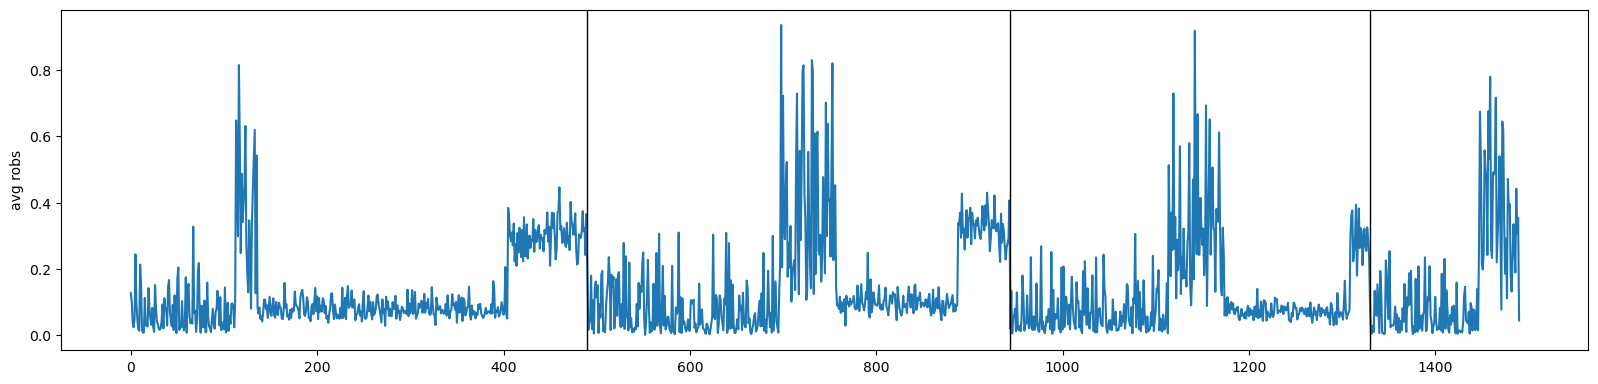

In [59]:
ss()
plt.plot(avg_robs[group0_idx+group1_idx+group2_idx+group3_idx])
plt.axvline(x=len(group0_idx)-0.5, color='black', lw=1)
plt.axvline(x=len(group0_idx+group1_idx)-0.5, color='black', lw=1)
plt.axvline(x=len(group0_idx+group1_idx+group2_idx)-0.5, color='black', lw=1)
plt.ylabel('avg robs')
plt.show()

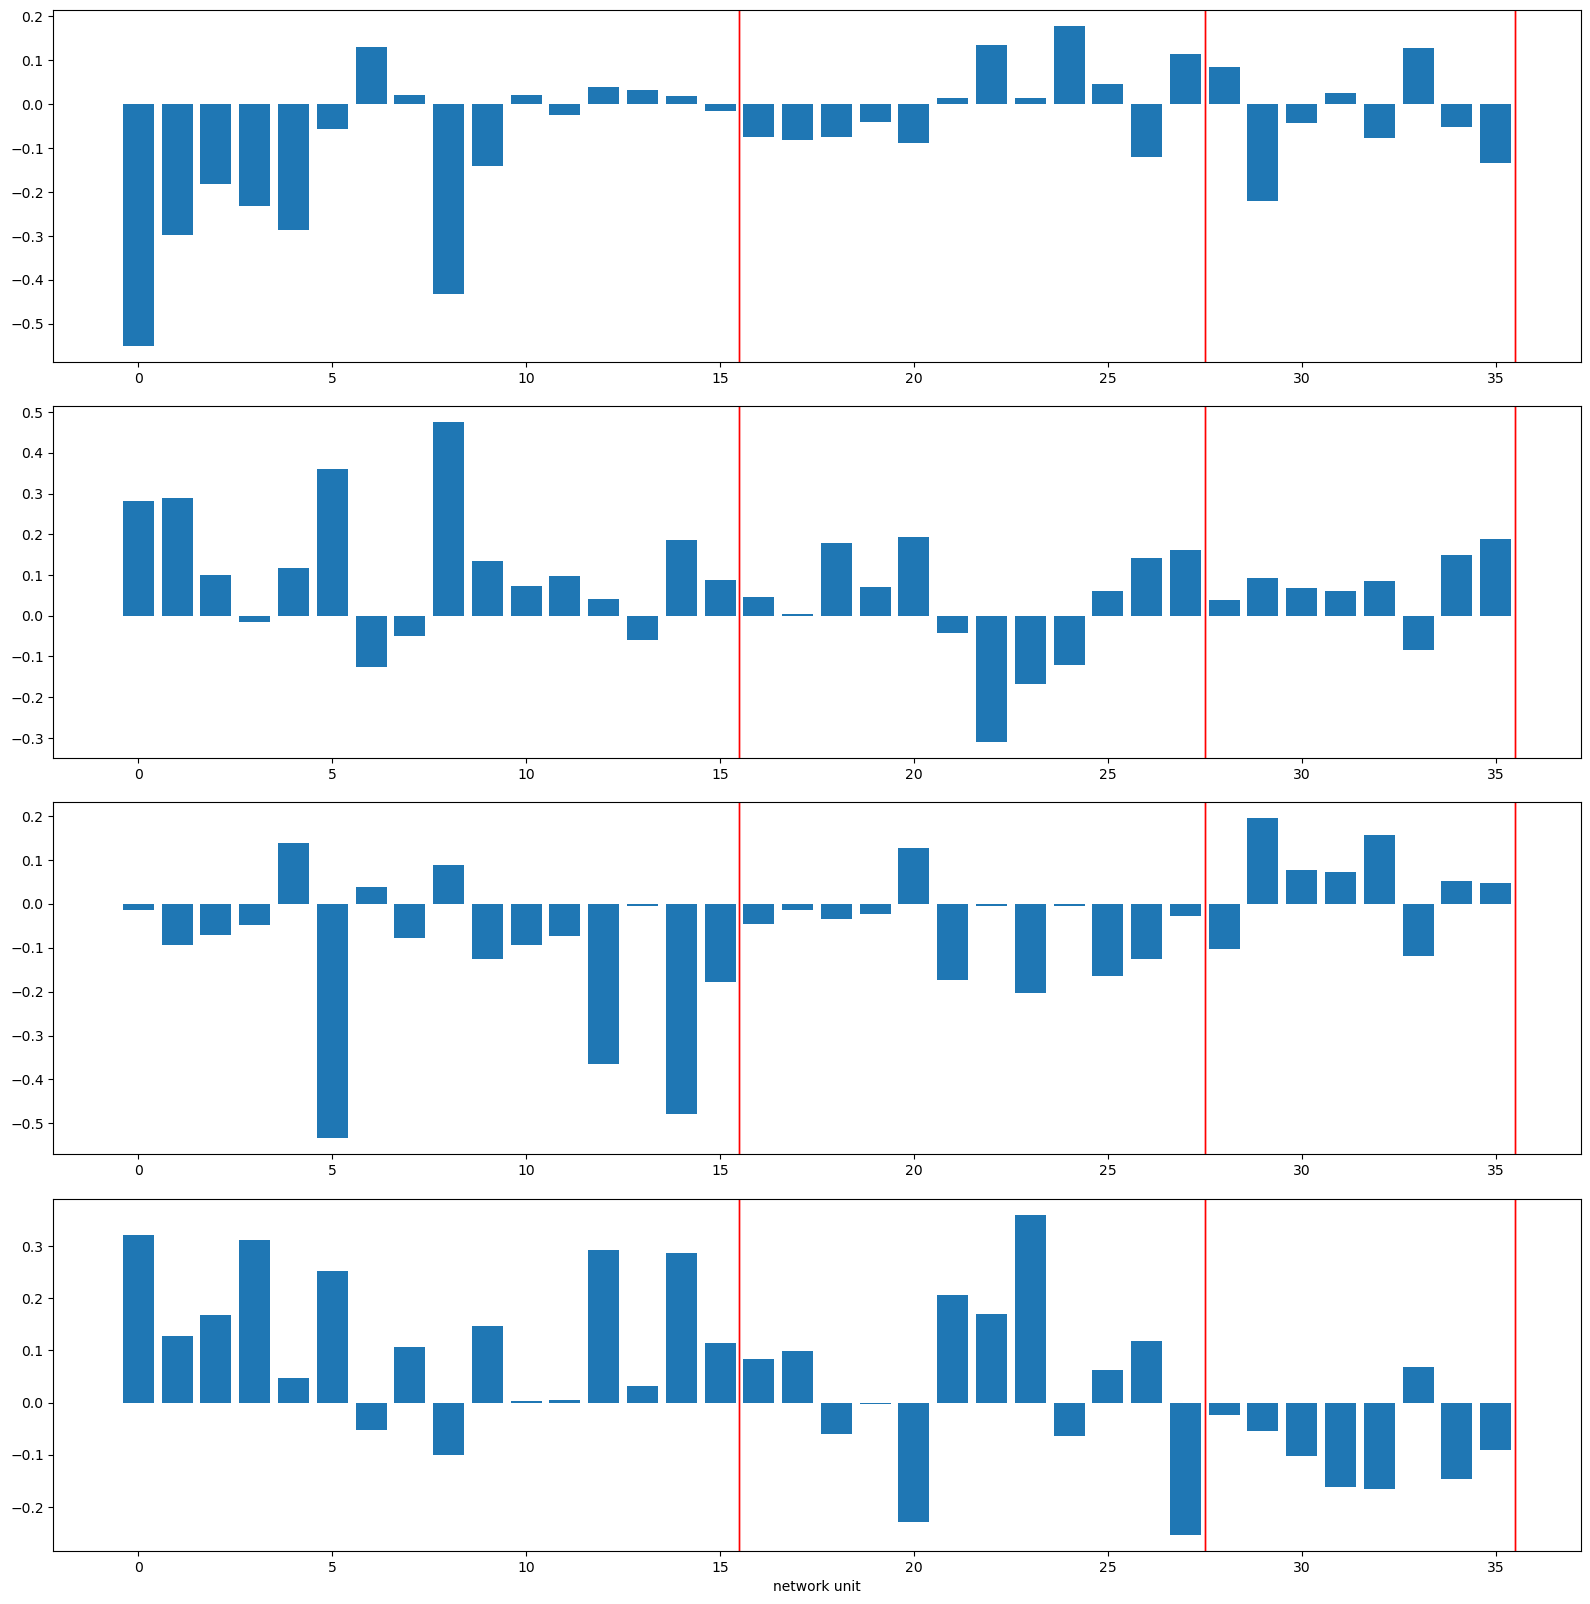

In [45]:
ss(4,1)
plt.subplot(4,1,1)
plt.bar(np.arange(a_hat.shape[0]), a_hat[:,0])
for i in range(len(barcode_idx)):
    plt.axvline(x=barcode_idx[i]-0.5, color='red', lw=1)
plt.subplot(4,1,2)
plt.bar(np.arange(a_hat.shape[0]), a_hat[:,1])
for i in range(len(barcode_idx)):
    plt.axvline(x=barcode_idx[i]-0.5, color='red', lw=1)
plt.subplot(4,1,3)
plt.bar(np.arange(a_hat.shape[0]), a_hat[:,2])
for i in range(len(barcode_idx)):
    plt.axvline(x=barcode_idx[i]-0.5, color='red', lw=1)
plt.subplot(4,1,4)
plt.bar(np.arange(a_hat.shape[0]), a_hat[:,3])
for i in range(len(barcode_idx)):
    plt.axvline(x=barcode_idx[i]-0.5, color='red', lw=1)
plt.xlabel('network unit')
plt.show()

In [60]:
BC.set_cells()
W = BC.get_barcode(space='filter')

proj = W.T@basis
proj.shape

(1491, 3)

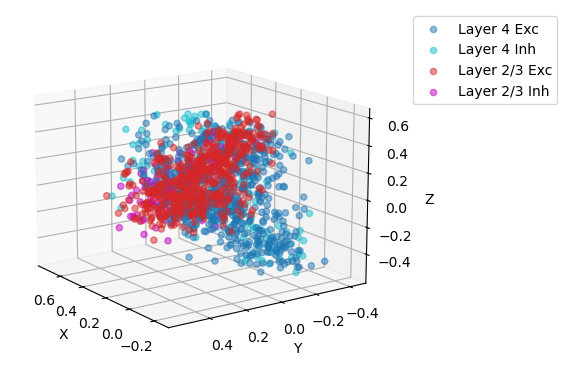

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(proj[L4_exc_idx,0], proj[L4_exc_idx,1], proj[L4_exc_idx,2], label='Layer 4 Exc', alpha=0.5, color=colors[0])
ax.scatter(proj[L4_inh_idx,0], proj[L4_inh_idx,1], proj[L4_inh_idx,2], label='Layer 4 Inh', alpha=0.5, color=colors[1])
ax.scatter(proj[L23_exc_idx,0], proj[L23_exc_idx,1], proj[L23_exc_idx,2], label='Layer 2/3 Exc', alpha=0.5, color=colors[2])
ax.scatter(proj[L23_inh_idx,0], proj[L23_inh_idx,1], proj[L23_inh_idx,2], label='Layer 2/3 Inh', alpha=0.5, color=colors[3])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(bbox_to_anchor=(1.5, 1))
#ax.set_title('Non-Sorted')
ax.view_init(elev=15, azim=145, roll=0)
plt.show()

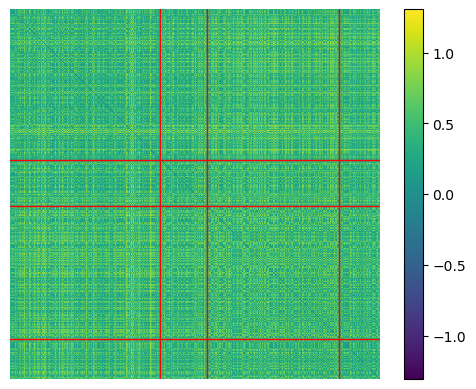

In [62]:
p_dist = distance_matrix(proj, proj)
imagesc(p_dist)
plt.axvline(x=L4_exc_idx[-1], color='red', lw=1)
plt.axhline(y=L4_exc_idx[-1], color='red', lw=1)
plt.axvline(x=L4_inh_idx[-1], color='red', lw=1)
plt.axhline(y=L4_inh_idx[-1], color='red', lw=1)
plt.axvline(x=L23_exc_idx[-1], color='red', lw=1)
plt.axhline(y=L23_exc_idx[-1], color='red', lw=1)
#plt.clim(0,1)
plt.colorbar()
plt.axis('off')
plt.show()

In [63]:
proj_df = pd.DataFrame(proj, columns=['x','y','z'])
proj_df['cell num'] = np.arange(NC)
proj_df['complexity'] = comp
proj_df['R2'] = R2
proj_df['cell type'] = cell_key
proj_df['group num'] = [str(i+1) for i in ac_pred]

In [64]:
fig = px.scatter_3d(proj_df, x='x', y='y', z='z', color='cell type', hover_data=['cell num', 'complexity'],
                    color_discrete_sequence=["#636EFA", "#19D3F3", "#EF553B", "#FF97FF"],
                    width=800, height=600, opacity=0.5)
fig.update_traces(marker=dict(size=4))
fig.show(renderer='iframe')